In [1]:
import pandas as pd

In [2]:
sarcasm_headlines = pd.read_json("../data/sarcasm-headlines.json", lines=True)
sarcasm_headlines.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
sarcasm_headlines['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [4]:
sarcastic_headlines = sarcasm_headlines[sarcasm_headlines['is_sarcastic'] == 1]
sarcastic_headlines.shape

(11724, 3)

In [5]:
not_sarcastic_headlines = sarcasm_headlines[sarcasm_headlines['is_sarcastic'] == 0]
not_sarcastic_headlines.shape

(14985, 3)

In [6]:
not_sarcastic_headlines = not_sarcastic_headlines.sample(sarcastic_headlines.shape[0])
not_sarcastic_headlines.shape

(11724, 3)

In [7]:
sarcasm_headlines = pd.concat([sarcastic_headlines, not_sarcastic_headlines])
sarcasm_headlines.shape

(23448, 3)

In [8]:
sarcasm_headlines['is_sarcastic'].value_counts()

is_sarcastic
1    11724
0    11724
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = sarcasm_headlines['headline']
y = sarcasm_headlines['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=sarcasm_headlines['is_sarcastic'])

In [11]:
preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/2"

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

C:\Users\bekasker\miniconda3\envs\python3.10\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [13]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(preprocessor_url)
encoder_inputs = preprocessor(text_input)

In [14]:
encoder = hub.KerasLayer(encoder_url)
outputs = encoder(encoder_inputs)

pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

In [15]:
layer = tf.keras.layers.Dropout(0.1, name='dropout')(pooled_output)
layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(layer)

model = tf.keras.Model(inputs=[text_input], outputs=[layer])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [17]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [18]:
model.fit(X_train, y_train, epochs=1)

550/550 [==============================] - 193s 339ms/step - loss: 0.6777 - accuracy: 0.5803 - precision: 0.5761 - recall: 0.6081


In [19]:
eval_results = model.evaluate(X_test, y_test)

184/184 [==============================] - 63s 339ms/step - loss: 0.6409 - accuracy: 0.6411 - precision: 0.6227 - recall: 0.7158


In [21]:
from datetime import datetime

In [30]:
accuracy = eval_results[model.metrics_names.index('accuracy')]
date = datetime.now().strftime("%d%m%Y")

model_name = f"smallbert_L10H128A2_{date}_epoch1_accuracy{accuracy:.2f}.keras"
model.save(f"../models/{model_name}")

In [31]:
import numpy as np

In [32]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

184/184 [==============================] - 62s 333ms/step


In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
cm = confusion_matrix(y_test, y_pred) 

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

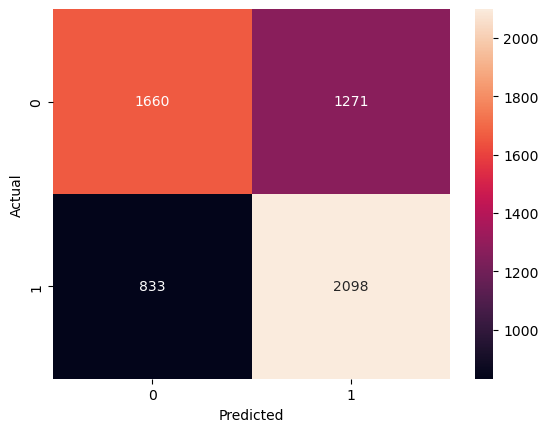

In [42]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.57      0.61      2931
           1       0.62      0.72      0.67      2931

    accuracy                           0.64      5862
   macro avg       0.64      0.64      0.64      5862
weighted avg       0.64      0.64      0.64      5862

